In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pickle
import tree_utils
import time

from tqdm import trange, tqdm
from collections import defaultdict, deque, namedtuple

A lot of these functions were copied over from https://github.com/mggg/GerryChain/blob/recom-fixes/gerrychain/tree.py for testing. 

In [2]:
class PopulatedGraph:
    def __init__(self, graph, populations, ideal_pop, epsilon):
        self.graph = graph
        self.subsets = {node: {node} for node in graph}
        self.population = populations.copy()
        self.tot_pop = sum(self.population.values())
        self.ideal_pop = ideal_pop
        self.epsilon = epsilon
        self._degrees = {node: graph.degree(node) for node in graph}
    
    def __iter__(self):
        return iter(self.graph)
    
    def degree(self, node):
        return self._degrees[node]
    
    def contract_node(self, node, parent):
        self.population[parent] += self.population[node]
        self.subsets[parent] |= self.subsets[node]
        self._degrees[parent] -= 1
    
    def has_ideal_population(self, node):
        return (
            (
                abs(self.population[node] - self.ideal_pop) <=
                self.epsilon * self.ideal_pop
            ) or 
            (
                abs(self.population[node] - (self.tot_pop - self.ideal_pop)) <=
                self.epsilon * self.ideal_pop
            )
        )

def predecessors(h, root):
    return {a: b for a, b in nx.bfs_predecessors(h, root)}

def successors(h, root):
    return {a: b for a, b in nx.bfs_successors(h, root)}

def find_balanced_edge_cuts_contraction(h, choice=random.choice):
    # this used to be greater than 2 but failed on small grids:(
    root = choice([x for x in h if h.degree(x) > 1])
    # BFS predecessors for iteratively contracting leaves
    pred = predecessors(h.graph, root)

    cuts = []
    leaves = deque(x for x in h if h.degree(x) == 1)
    while len(leaves) > 0:
        leaf = leaves.popleft()
        if h.has_ideal_population(leaf):
            cuts.append(Cut(edge=(leaf, pred[leaf]), subset=h.subsets[leaf].copy()))
        # Contract the leaf:
        parent = pred[leaf]
        h.contract_node(leaf, parent)
        if h.degree(parent) == 1 and parent != root:
            leaves.append(parent)
    return cuts

def find_balanced_edge_cuts_memoization(h, choice=random.choice):
    root = choice([x for x in h if h.degree(x) > 1])
    pred = predecessors(h.graph, root)
    succ = successors(h.graph, root)
    total_pop = h.tot_pop
    subtree_pops = {}
    stack = deque(n for n in succ[root])
    while stack:
        next_node = stack.pop()
        if next_node not in subtree_pops:
            if next_node in succ:
                children = succ[next_node]
                if all(c in subtree_pops for c in children):
                    subtree_pops[next_node] = sum(subtree_pops[c] for c in children)
                    subtree_pops[next_node] += h.population[next_node]            
                else:
                    stack.append(next_node)
                    for c in children:
                        if c not in subtree_pops:
                            stack.append(c)
            else:
                subtree_pops[next_node] = h.population[next_node]
    
    cuts = []
    for node, tree_pop in subtree_pops.items():
        # TODO: clean this up! there might be a networkx builtin
        def part_nodes(start):
            nodes = set()
            queue = deque([start])
            while queue:
                next_node = queue.pop()
                if next_node not in nodes:
                    nodes.add(next_node)
                    if next_node in succ:
                        for c in succ[next_node]:
                            if c not in nodes:
                                queue.append(c)
            return nodes

        if abs(tree_pop - h.ideal_pop) <= h.ideal_pop * h.epsilon:
            cuts.append(Cut(edge=(node, pred[node]), subset=part_nodes(node)))
        elif abs((total_pop - tree_pop) - h.ideal_pop) <= h.ideal_pop * h.epsilon:
            cuts.append(Cut(edge=(node, pred[node]),
                            subset=set(h.graph.nodes) - part_nodes(node)))
    return cuts

Cut = namedtuple("Cut", "edge subset")

def population_distributions(g):
    """ Returns an array of tuples of ("distribution name", population distribution) 
        as a tuple on graph `g`.
        
        The population distributions are dicts of the form {node : population}.
    """
    all_ones = ("All ones", {n: 1 for n in g.nodes})
    all_zeros = ("All zeros", {n: 0 for n in g.nodes})
    corners = ("Corners", {n: 1 if n in [(0, 0), (0, dim-1), (dim-1, 0), (dim-1, dim-1)] else 0 for n in g.nodes})
    random_pops = ("Random", {n: random.randint(1, 3) for n in g.nodes})
    
    return [all_ones, all_zeros, corners, random_pops]

def test_parity_between_balanced_edge_functions(spanning_trees, epsilon, pop_dists, target_pops):
    """ Tests that the functions `find_balanced_edge_cuts_memoization()` and
                                 `find_balanced_edge_cuts_contracttion()`
        produce the same set of cut edges for all the `spanning_trees`.
        
        Args:
            spanning_trees: A dict of the form {Int: Array(Tuple of Edges)}
                            Each Edge is of the form, for eg ((0, 1), (0, 2)) where it connects
                            the nodes (0, 1) and (0, 2)
            epsilon       : Float [0-1] that is the % deviation allowed from the target population
            pop_dists     : Array of Tuples of the form ("Distribution Name", dist). The dist is a dict
                            of the form for eg. {(0, 1) : x, ...} where (0, 1) is the node and the x 
                            is the population at that node.
            target_pops   : An array of numbers corresponding to the target pop of each pop distribution
                            in `pop_dists`.
    """
    for i, (dist_name, pops) in enumerate(pop_dists):
        for k, sp_trees in tqdm(spanning_trees.items()):
            for sp_tree_edges in sp_trees:
                
                sp_tree = nx.Graph(sp_tree_edges)
                pop_graph = PopulatedGraph(sp_tree, pops, target_pops[i], epsilon)

                balance_edges_memo = find_balanced_edge_cuts_memoization(pop_graph)
                balance_edges_contract = find_balanced_edge_cuts_contraction(pop_graph)
                memo_e = set(tuple(sorted(e.edge)) for e in balance_edges_memo)
                contract_e = set(tuple(sorted(e.edge)) for e in balance_edges_contract)
                assert memo_e == contract_e
                
def test_balanced_edge_functions_against_truth(tree, pops, true_balanced_edges, epsilon):
    """ Computes the balanced edges for `tree` and compares them against `true_balanced_edges`.
        
        Args:
            tree                : Networkx Graph with that is a spanning tree.
            pops                : A dict of populations at each node in `tree` of the form {(0, 1): pop} 
                                  where the key is the node.
            true_balanced_edges : A set of tuples, where each tuple is a collection of edges that are 
                                  the balanced edge cuts for `tree`.
            epsilon             : Float [0-1] that is the % deviation allowed from the target population
            
    """
    target_pop = sum(pops.values()) / 2
    pop_graph = PopulatedGraph(tree, pops, target_pop, epsilon)
    node_colors = [pops[i] for i in tree.nodes]
    tree_utils.draw(tree, node_colors=node_colors)

    # compute balanced edges from functions 
    balance_edges_memo = find_balanced_edge_cuts_memoization(pop_graph)
    balance_edges_contract = find_balanced_edge_cuts_contraction(pop_graph)
    memo_e = set(tuple(sorted(e.edge)) for e in balance_edges_memo)
    contract_e = set(tuple(sorted(e.edge)) for e in balance_edges_contract)

    # test against truth
    assert(true_balanced_edges == memo_e)
    assert(true_balanced_edges == contract_e)

In [4]:
dims = [3, 4]
epsilon = 0.02 # ±1 node

for dim in dims:
    filename = "{}x{}_STs.p".format(dim, dim)
    
    with open(filename, "rb") as openfile:
        spanning_trees = pickle.load(openfile)
    
    g = nx.grid_graph(dim=[dim, dim])
    pop_dists = population_distributions(g)
    target_pops = [sum(dist[1].values())/2 for dist in pop_dists]
    
    test_parity_between_balanced_edge_functions(spanning_trees, epsilon, pop_dists, target_pops)

100%|██████████| 11/11 [00:22<00:00,  2.06s/it]


## Custom Test Cases

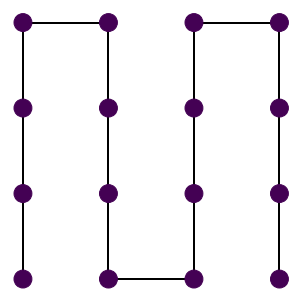

In [5]:
# Test Case: Snake-like Tree where all populations are 1.

snake_tree = (((0, 0), (0, 1)), ((0, 1), (0, 2)), ((0, 2), (0, 3)), ((0, 3), (1, 3)), 
              ((1, 2), (1, 3)), ((1, 1), (1, 2)), ((1, 0), (1, 1)), ((1, 0), (2, 0)), 
              ((2, 0), (2, 1)), ((2, 1), (2, 2)), ((2, 2), (2, 3)), ((2, 3), (3, 3)), 
              ((3, 3), (3, 2)), ((3, 2), (3, 1)), ((3, 0), (3, 1)))
sp_tree = nx.Graph(snake_tree)
pops = {n: 1 for n in sp_tree.nodes}
true_balanced_edges = {((1, 0), (2, 0))}
test_balanced_edge_functions_against_truth(sp_tree, pops, true_balanced_edges, epsilon)

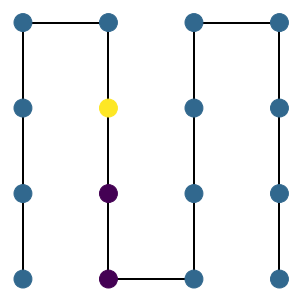

In [6]:
# Test Case 2: Snake like tree with imbalanced population distribution.

snake_tree_imbalanced = (((0, 0), (0, 1)), ((0, 1), (0, 2)), ((0, 2), (0, 3)), ((0, 3), (1, 3)), 
                         ((1, 2), (1, 3)), ((1, 1), (1, 2)), ((1, 0), (1, 1)), ((1, 0), (2, 0)), 
                         ((2, 0), (2, 1)), ((2, 1), (2, 2)), ((2, 2), (2, 3)), ((2, 3), (3, 3)), 
                         ((3, 3), (3, 2)), ((3, 2), (3, 1)), ((3, 0), (3, 1)))
sp_tree_imbalanced = nx.Graph(snake_tree_imbalanced)
pops = {n: 1 for n in sp_tree_imbalanced.nodes}
pops[(1,2)] = 3
pops[(1,1)] = 0
pops[(1,0)] = 0

true_balanced_edges = {((1, 0), (2, 0)),
                       ((1, 0), (1, 1)),
                       ((1, 1), (1, 2))
                      }

test_balanced_edge_functions_against_truth(sp_tree, pops, true_balanced_edges, epsilon)

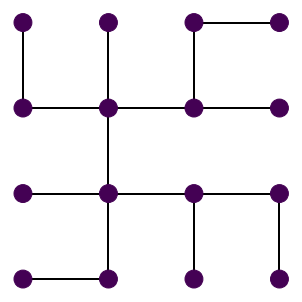

In [7]:
# Test Case 3: Sprawling tree with population = 1 at every node

sprawl_tree = (((0, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (0, 1)), ((1, 1), (2, 1)), 
               ((2, 1), (2, 0)), ((2, 1), (3, 1)), ((3, 1), (3, 0)), ((1, 1), (1, 2)), 
               ((1, 2), (0, 2)), ((0, 2), (0, 3)), ((1, 2), (1, 3)), ((1, 2), (2, 2)), 
               ((2, 2), (2, 3)), ((2, 3), (3, 3)), ((2, 2), (3, 2)))
sprawl_tree = nx.Graph(sprawl_tree)
pops = {n: 1 for n in sprawl_tree.nodes}

true_balanced_edges = {((1, 1), (1, 2))}
test_balanced_edge_functions_against_truth(sprawl_tree, pops, true_balanced_edges, epsilon)